# SEL634 - Laboratório de Robôs Manipuladores

## Inicialização da biblioteca

Carregar a biblioteca de robótica para Python:

In [2]:
!pip install roboticstoolbox-python
!pip install spatialmath-python

     |████████████████████████████████| 497 kB 8.5 MB/s 
     |████████████████████████████████| 40 kB 4.7 MB/s 
     |████████████████████████████████| 93.7 MB 39 kB/s 
     |████████████████████████████████| 5.7 MB 37.2 MB/s 
     |████████████████████████████████| 162 kB 51.2 MB/s 
     |████████████████████████████████| 112 kB 54.3 MB/s 
     |████████████████████████████████| 121 kB 58.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for spatialmath-python: filename=spatialmath_python-0.11-py3-none-any.whl size=174332 sha256=d0149a7f99f06506f8c3e9409d6569d84d805998c39a220652a813de45b72813
  Stored in directory: /root/.cache/pip/wheels/08/10/77/0442f623dc37f46361d78c136f79aaf22c30b5c493c0b120b5
  Created wheel for ansitable: filename=ansitable-0.9.6-py3-none-any.whl size=12621 sha256=812630d4d609c56639ef69170d35c42982d426cc8d904d8b078e04e5037b962a
  Stored in directory: /root/.cache

In [3]:
import numpy as np
#import roboticstoolbox as rtb
from roboticstoolbox import *
from spatialmath import *
from math import pi
import matplotlib.pyplot as plt
from matplotlib import cm
np.set_printoptions(linewidth=100, formatter={'float': lambda x: f"{x:8.4g}" if abs(x) > 1e-10 else f"{0:8.4g}"})

# no Binder utilizar essa linha
#%matplotlib notebook  
# no Colab utilizar essa linha
%matplotlib inline

## Cinemática Direta do Robô Kinova Gen3

O robô Kinova Gen3 pode ser modelado pela seguinte função (ver Tarefa 2):

In [4]:
def kinova_robot(my_name):
  robot = DHRobot(
      [
       # Colocar seu código aqui para completar a descrição do robô
        RevoluteDH(d=-(0.1564+0.1284), alpha=pi/2),
            RevoluteDH(d=-(0.0054+0.0064), alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.2104+0.2104), alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.0064+0.0064), alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.2084+0.1059), alpha=pi/2, offset=pi),
            RevoluteDH(alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.1059+0.0615), alpha=pi, offset=pi)
       ], name=my_name)
  H_B0 = SE3.Rz(0)*SE3(0,0,0)*SE3(0,0,0)*SE3.Rx(pi)
  robot.base = H_B0
  return robot


A pose do efetuador do robô Kinova Gen3 é dada em relação a base, $B$, pela função:

In [5]:
#def pose_efetuador(robot, q):
  #H_B0 = SE3.Rz(0)*SE3(0,0,0)*SE3(0,0,0)*SE3.Rx(pi)
  #H_07 = robot.fkine(q)
  #return H_B0*H_07

def pose_efetuador(robot, q):
  H_B7 = robot.fkine(q)
  return H_B7

## Tarefa 3 - Trajetória do Robô no Espaço das Juntas

De modo geral, existem duas formas de descrever trajetórias para um robô manipulador: especificar trajetórias no espaço de configuração, ou especificar trajetórias no espaço da tarefa. 

Nesta experiência serão especificadas as trajetórias no espaço de configuração, ou seja, serão especificadas trajetórias para cada junta do robô, e através da cinemática direta serão calculadas a posição e orientação do efetuador para cada configuração do robô.

Através de um polinômio de quinta ordem é possível obter uma trajetória suave para junta ao definir a posição, velocidade e aceleração inicial e final no intervalo de tempo da trajetória. 

**Polinômio de quinta ordem:** Considere que a junta $i$ possui a seguinte trajetória  em graus no tempo que leva a junta $i$ da posição $\theta_{si}$ até $\theta_{gi}$ em um intervalo de tempo $T_d$:
$$ \theta_i (t) = c_{0i} + c_{1i} t + c_{2i} t^2 + c_{3i} t^3 + c_{4i} t^4 + c_{5i} t^5 $$
Para velocidades e acelerações iniciais e finais iguais a zero, os coeficientes do polinômio são dados em função da posição inicial e final e do intervalo de tempo:
\begin{eqnarray*}
	&c_{0i}& = \theta_{si}\\
	&c_{1i}& = c_{2i} = 0\\
	&c_{3i}& = \frac{10(\theta_{gi}-\theta_{si})}{T_d^{3}}\\
	&c_{4i}& = \frac{15(\theta_{si}-\theta_{gi})}{T_d^{4}}\\
	&c_{5i}& = \frac{6(\theta_{gi}-\theta_{si})}{T_d^{5}}
\end{eqnarray*}

A velocidade de cada junta para condições iniciais nulas é dada por:
$$ \dot\theta_i (t) = c_{1i} + 2c_{2i} t + 3c_{3i} t^2 + 4c_{4i} t^3 + 5c_{5i} t^4 $$

A aceleração de cada junta para condições iniciais nulas é dada por:
$$ \ddot\theta_i (t) = 2c_{2i} + 6c_{3i} t + 12c_{4i} t^2 + 20c_{5i} t^3 $$


### 3.1 **Escreva uma função para calcular a trajetória das juntas do manipulador.** 

**A função deve ter como entrada:** um vetor $\theta_s$ com as posições iniciais das $N$ juntas do manipulador, um vetor $\theta_g$ com as posições finais das $N$ juntas do manipulador, o intervalo de tempo total do movimento $T_d$, o intervalo de tempo entre cada ponto da trajetória $\delta t$. 

**A função deve ter como saída:** uma matriz $\theta$ que descreve a posição de cada junta no tempo, e que possui dimensão $M \times N$, onde $N$ é o número de juntas do manipulador, $M$ é a quantidade de pontos da trajetória de cada junta ($M = T_d / \delta t$); uma matriz $d\theta$ com dimensão $M \times N$ que descreve a velocidade de cada junta no tempo; uma matriz $dd\theta$ com dimensão $M \times N$ que descreve a aceleração de cada junta no tempo. 

**Observação:** Não utilize a derivada numérica discreta para encontrar a velocidade e aceleração. Calcule a velocidade e aceleração a partir das suas funções analíticas. Também não utilize loop para encontrar os pontos das curvas, ao invés disso, crie um vetor de tempo com $M$ elementos de $0$ a $T_d$, e use esse vetor diretamente no calculo das trajetórias. 

In [6]:
def calcular_trajetoria(theta_s, theta_g, Td, dt):
  
  t = np.arange(0,Td+dt,dt)
  #print(t)

  M = t.size
  #print(M)

  N = theta_s.size
  #print(N)

  C = np.ones((M,1)) # Matriz de 1s de dimensão NxM
 
  a1 = ((10*(theta_g - theta_s)/(Td**3)).reshape(N,1))*((t**3).reshape(1,M))
  b1 = ((15*(theta_s - theta_g)/(Td**4)).reshape(N,1))*((t**4).reshape(1,M))
  c1 = ((6*(theta_g - theta_s)/(Td**5)).reshape(N,1))*((t**5).reshape(1,M))
  #print(a1.shape, b1.shape, c1.shape)

  a2 = ((30*(theta_g - theta_s)/Td**3).reshape(N,1))*((t**2).reshape(1,M)) 
  b2 = ((60*(theta_s - theta_g)/Td**4).reshape(N,1))*((t**3).reshape(1,M))
  c2 = ((30*(theta_g - theta_s)/Td**5).reshape(N,1))*((t**4).reshape(1,M))
  #print(a2.shape, b2.shape, c2.shape)

  a3 = np.dot((60*(theta_g - theta_s)/Td**3).reshape(N,1),(t).reshape(1,M)) 
  b3 = np.dot((180*(theta_s - theta_g)/Td**4).reshape(N,1),(t**2).reshape(1,M))
  c3 = np.dot((120*(theta_g - theta_s)/Td**5).reshape(N,1),(t**3).reshape(1,M))
  #print(a2.shape, b2.shape, c2.shape)

  theta_t = (((theta_s.reshape(N,1))*(C.reshape(1,M))) + a1 + b1 + c1).T 
  dtheta_t = (a2 + b2 + c2).T 
  ddtheta_t = (a3 + b3 + c3).T

  return theta_t, dtheta_t, ddtheta_t, t



### 3.2 Escreva uma função para plotar as curvas de posição, velocidade e aceleração em função do tempo para cada junta do robô. 

O programa deve plotar 3 gráficos em função do tempo, um para a posição, um para velocidade e um para aceleração nas juntas. Em cada um dos três gráficos, sobreponha as curvas para as juntas do robô identificando por cores diferentes cada uma das juntas. Não esqueça de colocar título nas figuras, rótulo para cada um dos eixos com a unidade de medida e significado, e legenda para as cores. 

**Entrada da função:** As mesmas entradas da função do item 3.1. 

In [9]:
def plota_curvas(theta_s, theta_g, Td, dt):

  theta_t, dtheta_t, ddtheta_t, t = calcular_trajetoria(theta_s,theta_g,Td,dt)

  plt.plot(t,theta_t)
  fig = plt.figure('Posição')
  plt.plot(t,dtheta_t)
  fig = plt.figure('Velocidade')
  plt.plot(t,ddtheta_t)
  fig = plt.figure('Aceleração')

  return theta_t, dtheta_t, ddtheta_t, t

# ------------------------------------------------------------------------------
# TESTE
Td = 10.0
dt = 0.01
theta_s = np.array([0,0,0,0,0,0,0])
theta_g = np.array([-pi/2,pi/2,0,-pi/2,0,pi/2,0])




### 3.3 Escreva uma função que calcule a cinemática direta do robô Kinova Gen3 para cada ponto da trajetória do robô no espaço das juntas

Para cada configuração do robô no tempo, $\mathbf{q} = [\theta_1~\theta_2~\theta_3~ \theta_4~ \theta_5~ \theta_6~ \theta_7]^T$, calcular matriz de transformação homogênea que representa a pose do efetuador em relação a base. 

**Entrada da função:** O modelo cinemático do robô Kinova Gen3 (resultado da Tarefa 2); a matriz $\theta$ de dimensão $M \times N$ resultado do item 3.1. 

**Saída da função:** um vetor `np.array` de matrizes de transformação homogênea (dimensão $M \times 4 \times 4$), em que para cada instante de tempo, a matriz de transformação homogênea representa a pose do robô (posição e orientação do efetuador). Consulte a seção 2.5 da tarefa 2.

In [10]:
def calcular_traj_efetuador(robot, theta_t):
   HH_efetuador = robot.fkine(theta_t)
   return HH_efetuador
#--------------------------------------------------------------------
def kinova_robot(my_name):
  robot = DHRobot(
      [
       # Colocar seu código aqui para completar a descrição do robô
       #RevoluteDH(alpha=pi),
            RevoluteDH(d=-(0.1564+0.1284), alpha=pi/2),
            RevoluteDH(d=-(0.0054+0.0064), alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.2104+0.2104), alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.0064+0.0064), alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.2084+0.1059), alpha=pi/2, offset=pi),
            RevoluteDH(alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.1059+0.0615), alpha=pi, offset=pi)
       ], name=my_name)
  H_B0 = SE3.Rz(0)*SE3(0,0,0)*SE3(0,0,0)*SE3.Rx(pi)
  robot.base = H_B0
  return robot
#--------------------------------------------------------------------



### 3.4 Escreva um programa para plotar a curva de posição cartesiana do efetuador em função do tempo. 

Essa curva 2D deve apresentar curvas em função do tempo de $x_e$,  $y_e$, e  $z_e$ sobrepostas identificas por cores diferentes. 

**Entrada da função:** um vetor `np.array` de matrizes de transformação homogênea (dimensão $M \times 4 \times 4$), em que para cada instante de tempo, a matriz de transformação homogênea representa a pose do robô (posição e orientação do efetuador); o intervalo de tempo entre cada ponto da trajetória $\delta t$. 

In [ ]:
def plotar_trajetoria_efetuador(HH_efetuador, dt):
  # Coloque seu codigo aqui

### 3.5 Escreva um programa para plotar a curva de orientação do efetuador em função do tempo. 

Essa curva 2D deve apresentar a orientação do efetuador em função do tempo descrita em ângulos de roll, pitch e yaw. Os ângulos de roll, pitch e yaw decem ser mostrados no mesmo gráfico com cores diferentes e claramente identificadas. Para cada instante de tempo, o calculo dos ângulos de roll, pitch e yaw devem ser feitos a partir da matriz de transformação homogênea.

**Entrada da função:** um vetor `np.array` de matrizes de transformação homogênea (dimensão $M \times 4 \times 4$), em que para cada instante de tempo, a matriz de transformação homogênea representa a pose do robô (posição e orientação do efetuador); o intervalo de tempo entre cada ponto da trajetória $\delta t$. 

In [ ]:
def plotar_orientacao_efetuador(HH_efetuador, dt):
  # Coloque seu codigo aqui

### 3.6 Teste das funções

Faça o teste das funções do item 3.2 a 3.5 para os seguintes parâmetros: $T_d = 10$ segundos, $\delta t = 0.01$ segundos,  posição inicial das juntas $\theta_s = [0, 0, 0, 0, 0, 0, 0]^T$  e posição final das juntas $\theta_g = [90, 90, 0, -90, 0, 90, 0]^T$ dada em graus.

0:
   1         0         0         0         
   0         1         0        -0.0246    
   0         0         1         1.187     
   0         0         0         1         
1:
   1         8.987e-07  8.987e-07  5.065e-07  
  -8.987e-07  1        -8.073e-13 -0.0246    
  -8.987e-07  0         1         1.187     
   0         0         0         1         
2:
   1         7.178e-06  7.178e-06  4.046e-06  
  -7.178e-06  1        -5.153e-11 -0.0246    
  -7.178e-06  0         1         1.187     
   0         0         0         1         
3:
   1         2.419e-05  2.419e-05  1.363e-05  
  -2.419e-05  1        -5.852e-10 -0.0246    
  -2.419e-05  0         1         1.187     
   0         0         0         1         
4:
   1         5.725e-05  5.725e-05  3.227e-05  
  -5.725e-05  1        -3.278e-09 -0.0246    
  -5.725e-05  0         1         1.187     
   0         0         0         1         
5:
   1         0.0001117  0.0001117  6.293e-05  
  -0.0001117  1        -1.247e-

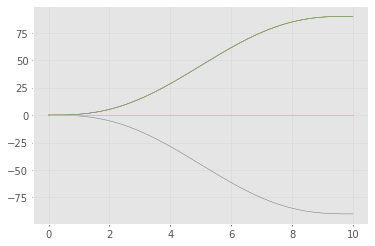

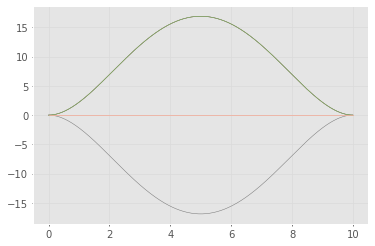

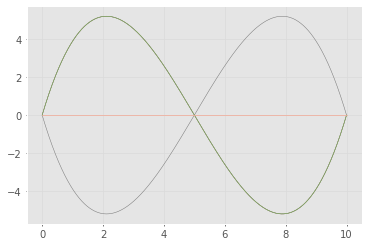

<Figure size 432x288 with 0 Axes>

In [11]:
# --------
# TESTE

Td = 10.0
dt = 0.01
theta_s = np.array([0,0,0,0,0,0,0])
theta_g = np.array([90,90,0,-90,0,90,0])

calcular_trajetoria(theta_s,theta_g,Td,dt)
theta_t, dtheta_t, ddtheta_t, t = plota_curvas(theta_s,theta_g,Td,dt)
robot = kinova_robot("KinovaGen3_P1")
calcular_traj_efetuador(robot, theta_t)

